# NLP GD-10 Transformer Translator

### 2023-01-30 (월)


### 한글 폰트 설정

In [198]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("슝=3")

슝=3


## 라이브러리 Import

In [199]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.9.0


## 트랜스포머 내부 모듈 구현하기

### 1) Positional Encoding

In [200]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

print("슝=3")

슝=3


### 2) Multi-Head Attention

In [201]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model                     # 512
        
        self.depth = d_model // self.num_heads     # 512/8 = 64
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)

        """
        Scaled QK 값 구하기
        """
        dk = tf.cast(K.shape[-1], tf.float32) # K의 차원수를 float32형으로 변환
        QK = tf.matmul(Q, K, trainspose_b=True) # QKT
        
        scaled_qk = QK/tf.math.sqrt(dk)
        

        if mask is not None: scaled_qk += (mask * -1e9) 

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        atteentions = tf.nn.softmax(scaled_qk, axis=-1) # 계산된 QK^T/sqrt(dK)값을 소프트맥스하여 확률 값으로 변환한 것이 어텐션
        out = tf.matmul(attentions, V) # 어텐션과 밸류(V)의 내적이 출력값
        
        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ] # [64, 40, 512]
        return: [ batch x length x heads x self.depth ] 
        """
        batch_size = x.shape[0]   # 64                  # 512//8 == 64
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth)) # (64,-1, 8, 64)
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3]) # (64, 8, [40], 64) 
        # (batch_size, num_heads, length, depth)

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수
                                                    # (batch_size, num_heads, length, depth)
        x: [ batch x length x heads x self.depth ]  # [64, 8, 40, 64]
        return: [ batch x length x emb ]            # [64, 40, -1(512)] 
        """
        batch_size = x.shape[0]
        # combined_x = tf.transpose(x, perm[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))
        
        return combined_x
    

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out
        """
        # Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        # Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
           
        # Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
        #         -> out, attention_weights                
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
        
        # Step 4: Combine Heads(out) -> out
        out = self.combine_heads(out)
        
        # Step 5: Linear_out(out) -> out
        out = self.linear(out)
        
        return out, attention_weights

print("슝=3")

슝=3


### Position-wise Feed-Forward Network

* d_ff : 논문의 설명대로라면 2048  
* d_model : 512


* [ batch x length x d_model ]의 입력을 받아

-> w_1 이 2048차원으로 매핑  
-> 활성함수 ReLU를 적용  

-> 다시 w_2 를 통해 512차원으로 되돌리는 과정


In [202]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):                            # 512, 2048
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu') # 2048
        self.w_2 = tf.keras.layers.Dense(d_model)                 # 512

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


## 트랜스포머 모듈 조립하기

### 레이어 구현

#### Encoder 레이어 구현

Transformer의 구현은 정말 많은데, 그중에서 Normalization Layer의 위치에 대한 논의가 종종 나온답니다. 실제 논문에서는 [Input] - [Module] - [Residual] - [Norm] (Module = MHA, FFN)으로 표현되어 있지만 정작 Official 구현인 구글의 Tensor2Tensor 에서는 [Input] - [Norm] - [Module] - [Residual] 방식을 사용했어요.

필자의 경험에 따르면 레이어가 많아질수록 후자가 약간 더 좋은 성능을 보였기에 필자는 논문 대신 Official 구현을 따르길 권장합니다! 이번 프로젝트는 소규모라서 큰 차이가 나지 않으니 알아두기만 해도 괜찮아요. 😃

트랜스포머의 Layer Normalization의 위치에 대한 논의를 다룬 [On Layer Normalization in the Transformer Architecture](https://arxiv.org/pdf/2002.04745.pdf)이라는 제목의 논문이 2020년 초반에 발표되었습니다. 이 논문에서는 모듈 앞에 Normalization Layer를 두는 pre-LN 방식이 왜 유리한지를 설명하고 있습니다.

In [203]:

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):                # 512, 8, 2048, 0.0
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)       # (512, 8)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)                 # (512, 2048)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)                 # 0.0
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x                                                    # for residual connection
        out = self.norm_1(x)                                            # layer normalization
        out, enc_attn = self.enc_self_attn(out, out, out, mask)         # multi head attention 
        out = self.dropout(out)                                         # dropout
        out += residual                                                 # residual connection
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out                                                  # for residual connection
        out = self.norm_2(out)                                          # layer normalization
        out = self.ffn(out)                                             # Position-wise Feed forward network
        out = self.dropout(out)                                         # dropout
        out += residual                                                 # residual connection
        
        return out, enc_attn

print("슝=3")

슝=3


#### 디코더 레이어 구현

위 EncoderLayer 클래스를 참고하여 DecoderLayer 클래스를 완성하세요!  
(참고: Decoder에서는 두 번의 Attention이 진행되니 반환되는 Attention도 두 개겠죠?)

In [204]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):               # 512, 8, 2048, 0.0
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)      # (512, 8)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)       # (512, 8)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)                  # (512, 2048)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)   
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):
        
        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn
 

### 인코더-디코더 구현

#### 인코더 클래스 구현

In [205]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,        # 인코더 레이어의 층 수 6
                 d_model,         # 512
                 n_heads,         # 8
                 d_ff,            # 2048 
                 dropout):        # 0.1
        
        super(Encoder, self).__init__()
        
        self.n_layers = n_layers  # 8
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) # (512, 8, 2048, 0.0)
                        for _ in range(n_layers)]                        # 6
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):                                   # 6
            out, enc_attn = self.enc_layers[i](out, mask)                #
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


#### 디코더 클래스 구현

In [206]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


## Transformer 구현

정의된 Encoder 와 Decoder 를 가지고 최종적으로 트랜스포머를 완성합니다!

아래 조건을 만족하며 소스의 빈칸을 채워 Transformer 클래스를 완성하세요!

1. shared 변수를 매개변수로 받아 True 일 경우 Decoder Embedding과 출력층 Linear의 Weight를 공유 할 수 있게 하세요! Weight가 공유될 경우 Embedding 값에 sqrt(d_model) 을 곱해줘야 하는 것, 잊지 않으셨죠? (참고: tf.keras.layers.Layer.set_weights())


2. 우리가 정의한 positional_encoding 의 반환값 형태는 [ Length x d_model ] 인데, 이를 더해 줄 Embedding 값 형태가 [ Batch x Length x d_model ] 이라서 연산이 불가능합니다. 연산이 가능하도록 수정하세요! (참고: tf.expand_dims(), np.newaxis)


In [207]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,         # 6
                    d_model,          # 512
                    n_heads,          # 8 
                    d_ff,             # 2048
                    src_vocab_size,   # 30000
                    tgt_vocab_size,   # 30000
                    pos_len,          # 
                    dropout=0.1,
                    shared=True):        
        
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        
        # 1. Embedding Layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model) # (30000, 512)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model) # (30000, 512)

        # 2. Positional Encoding 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)         # (1024, 512)
               
        # 3. Encoder / Decoder 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout) # (6, 512, 8, 0.1)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout) # (6, 512, 8, 0.1)
        
        # 4. Output Linear 정의
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)                   # (30000)

        # 5. Shared Weights
        self.shared = shared
        if shared: 
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))
        
        #6. Dropout 정의
        self.dropout = tf.keras.layers.Dropout(dropout)                   # 0.1
        
    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

## 모델 밖의 조력자들

#### Mask

아까부터 은근하게 마음 한구석을 차지하고 있던 Masking을 살펴볼 시간이 다가왔습니다. 그리고 트랜스포머의 Learning Rate가 일반적이지 않다는 것도 기억하고 계실 거예요! 지금부터는 모델 외적인 부분을 정의해 주도록 하겠습니다. 이번 스텝에서는 데이터의 특성이나 학습 과정에 따라 달라지는 부분을 다루게 됩니다.

먼저 Masking입니다. 이전 노드에서 배운 generate_causality_mask() 를 그대로 사용하면 되는데, 약간 추가할 내용이 있습니다! 아래 구현을 먼저 보실까요?

In [208]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


generate_padding_mask() 는 Attention을 할 때에 <PAD> 토큰에도 Attention을 주는 것을 방지해 주는 역할을 합니다. 일전에 Sequence-to-Sequence 모델에서 Loss에 대한 Masking을 해줄 때도 위와 같은 방법으로 진행했죠? 한 배치의 데이터에서 <PAD> 토큰으로 이뤄진 부분을 모두 찾아내는 마스크를 생성합니다. 눈으로 직접 확인해보죠!

(16, 25)
(16, 35)


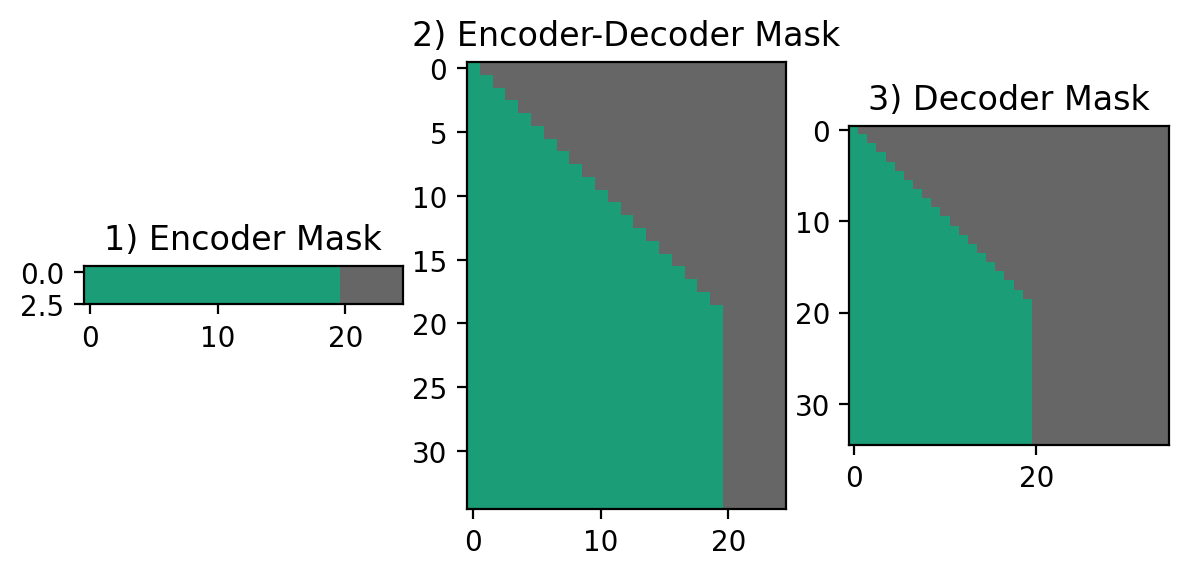

In [209]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding)) # (16, 5)
tgt_pad = tf.zeros(shape=(batch, tgt_padding)) # (16, 15)

sample_data = tf.ones(shape=(batch, length))   # (16, 20)

sample_src = tf.concat([sample_data, src_pad], axis=-1) # [16, 20], [16,5]
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1) # [16, 20], [16,15]

print(sample_src.shape)
print(sample_tgt.shape)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt) # [16, 20+5] [16, 20+15]

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

첫 번째 마스크는 각 배치 별로 데이터의 꼬리 부분을 Masking 하는 형태임을 알 수 있습니다. 낯선 부분은 두 번째와 세 번째의 Decoder가 연관된 마스크인데... 이것이 바로 Causality Mask와 Padding Mask를 결합한 형태입니다! 자기 회귀적인 특성을 살리기 위해 Masked Multi-Head Attention에서 인과 관계 마스킹을 했던 것을 기억하시죠? 인과 관계를 가리는 것도 중요하지만 Decoder 역시 <PAD> 토큰은 피해 가야 하기 때문에 이런 형태의 마스크가 사용된답니다!

#### LR Scheduler

또, 트랜스포머는 고정된 Learning Rate를 사용하지 않았었죠! 논문의 해당 부분을 Optimizer까지 포함하여 다시 한번 살펴봅시다. 이전 노드에서 Learning Rate를 numpy 로 간단히 구현을 했었는데, 이번엔 Tensorflow 상에서 잘 구동될 수 있도록 LearningRateSchedule 클래스를 상속받아 구현해보죠!

In [210]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

print("슝=3")

슝=3


트랜스포머가 제안한 수식이 아니더라도 가변적인 Learning Rate를 사용하려면 위와 같이 구현을 하시면 됩니다. Optimizer와 Scheduler를 연결하는 과정도 아주 간단하죠! Optimizer는 논문에 정의된 대로 Adam Optimizer를 사용하며 세부 파라미터도 동일하게 맞춰 줍니다.

# 프로젝트 : 더 멋진 번역기 만들기

### 라이브러리 버전을 확인해 봅니다.
---
사용할 라이브러리 버전을 둘러봅시다.

In [211]:
import tensorflow
import numpy
import matplotlib

print(tensorflow.__version__)
print(numpy.__version__)
print(matplotlib.__version__)

2.9.0
1.22.4
3.5.3


## Step 1. 데이터 다운로드 (클라우드 유저용)
---
아래 링크에서 korean-english-park.train.tar.gz 를 사용할 예정입니다. 다운로드할 필요는 없습니다.

* [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

☁️클라우드 환경에서는 위 데이터를 미리 준비해 놓았으니 연결만 시켜줍시다. 우측 하단의 Cloud shell을 열어주세요.
아래와 같이 공유 디렉토리에 저장된 데이터를 가리키는 심볼릭 링크를 생성해 주시면 됩니다.

$ ln -s ~/data ~/aiffel/transformer/data

## Step 2. 데이터 정제 및 토큰화
---
### 중복 데이타 제거 : Set

1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

#### 데이타 다운로드

In [212]:
data_dir = os.getenv('HOME')+'/aiffel/nlp/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

#### 데이타 살펴보기

##### 한글 데이타

In [213]:
with open(kor_path, "r") as f:
    ko_raw = f.read().splitlines()

print("Data Size:", len(ko_raw))
print("Example:")

for sen in ko_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


##### 영어 데이타

In [214]:
with open(eng_path, "r") as f:
    eng_raw = f.read().splitlines() # line 별로 split

print("Data Size:", len(eng_raw))
print("Example:")

for sen in eng_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


In [215]:
# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    # [[YOUR CODE]]
    cleaned_corpus = [] # concatenate both corpus into one

    for i in range(len(eng)) :
        cleaned_corpus.append(kor[i] +'\t'+ eng[i]) # eng + \t + kor

    #세트로 중복 제거
    cleaned_corpus = set(cleaned_corpus)

    return cleaned_corpus

In [216]:
cleaned_corpus = clean_corpus(kor_path, eng_path)

### 정제함수 정의

2. 정제 함수를 아래 조건을 만족하게 정의하세요.

> * 모든 입력을 소문자로 변환합니다.  
> * 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.  
> * 문장부호 양옆에 공백을 추가합니다.  
> * 문장 앞뒤의 불필요한 공백을 제거합니다.

In [217]:
from konlpy.tag import Mecab
mecab = Mecab()

def preprocess_sentence(sentence, kor=False):
    
    # [[YOUR CODE]]
    SOS = '[START]'
    EOS = '[END]'
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)    
    if kor:    
        sentence = re.sub(r"[^ㄱ-ㅎ가-힣?.!,]+", " ", sentence)
    else:
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
      
    return SOS + sentence.strip() + EOS

### 토큰화 : Sentencepiece

3. 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다! 토큰화에는 Sentencepiece를 활용하세요. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다. 
최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요. en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.
 
* google/sentencepiece

> * 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)  
> * 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.  
> * 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.  
>    < PAD > : 0  
>    < BOS > : 1  
>    < EOS > : 2   
>    < UNK > : 3


In [229]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
import sentencepiece as spm

def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    # [[YOUR CODE]]
    temp_file = os.getenv('HOME')+f'/aiffel/nlp/transformer/data/{lang}_spm.train.ko.temp'

    with open(temp_file, 'w') as f:
        for row in corpus: 
            f.write(str(row) + '\n')

    spm.SentencePieceTrainer.Train( 
        f'--input={temp_file}' + 
        f' --model_prefix={lang}_spm' +
        f' --vocab_size={vocab_size + 6}' + 
        f' --model_type=unigram' +
        # f' --max_sentence_length=50' +            # 문장 최대 길이
        f' --pad_id={pad_id} --pad_piece=[PAD]' + # pad
        f' --unk_id={unk_id} --unk_piece=[UNK]' + # unknown
        f' --bos_id={bos_id} --bos_piece=[BOS]' + # begin of sequence
        f' --eos_id={eos_id} --eos_piece=[EOS]' + # end of sequence
        f' --user_defined_symbols=[START],[END]') # 사용자 정의 토큰    
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{lang}_spm.model')

    return tokenizer    

In [230]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 29657 - 6

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair.split('\t')

    kor_corpus.append(preprocess_sentence(k, kor=True))
    eng_corpus.append(preprocess_sentence(e, kor=False))

In [231]:
ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, 'ko')
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, 'en')
en_tokenizer.set_encode_extra_options('bos:eos')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/Users/ksh/aiffel/nlp/transformer/data/ko_spm.train.ko.temp --model_prefix=ko_spm --vocab_size=29657 --model_type=unigram --pad_id=0 --pad_piece=[PAD] --unk_id=3 --unk_piece=[UNK] --bos_id=1 --bos_piece=[BOS] --eos_id=2 --eos_piece=[EOS] --user_defined_symbols=[START],[END]
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /Users/ksh/aiffel/nlp/transformer/data/ko_spm.train.ko.temp
  input_format: 
  model_prefix: ko_spm
  model_type: UNIGRAM
  vocab_size: 29657
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  

True

### 코퍼스 구측 : 토큰 길이 50 이하

4. 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환하세요! (❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)

In [232]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    # [[YOUR CODE]]
    source = ko_tokenizer.encode(kor_corpus[idx])
    target = en_tokenizer.encode(eng_corpus[idx])
    
    if len(source) < 51:
        src_corpus.append(source)
        tgt_corpus.append(target)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [233]:
print(ko_tokenizer.decode(src_corpus[0]))
print(en_tokenizer.decode(tgt_corpus[0]))

[START]여론조사에 의하면 미국 유권자의 분의 은 오바마가 미국에 대한 애국심이 부족하다고 밝혔다 .[END]
[START]One quarter of all registered voters say Obama lacks patriotism , according to the poll .[END]


## Step 3. 모델 설계
---
오늘 배운 내용을 활용해서 Transformer 모델을 설계해보세요!

### 트랜스포머 내부 모듈 구현

#### 위치 인코딩

In [234]:
#position encoding
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

#### 멀티헤드 어텐션

In [235]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)  
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

#### 위치기반 피드 포워드

In [236]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

### 트랜스포머 레이어 구현

#### 인코더 레이어

In [237]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

#### 디코더 레이어

In [238]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads) #+
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6) # +

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask) # masked 
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask) # Q,V encoder, mask
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### 트랜스포머 클래스 구현

#### 인코더 클래스 구현

In [239]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

#### 디코더 클래스 구현

In [240]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### 트랜스포머 모델 구현 

In [242]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,         # 6
                    d_model,          # 512
                    n_heads,          # 8 
                    d_ff,             # 2048
                    src_vocab_size,   # 30000
                    tgt_vocab_size,   # 30000
                    pos_len,          # 
                    dropout=0.1,
                    shared=True):        
        
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        
        # 1. Embedding Layer 정의
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model) # (30000, 512)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model) # (30000, 512)

        # 2. Positional Encoding 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)         # (1024, 512)
               
        # 3. Encoder / Decoder 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout) # (6, 512, 8, 0.1)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout) # (6, 512, 8, 0.1)
        
        # 4. Output Linear 정의
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)                   # (30000)

        # 5. Shared Weights
        self.shared = shared
        if shared: 
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))
        
        #6. Dropout 정의
        self.dropout = tf.keras.layers.Dropout(dropout)                   # 0.1
        
    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

### 보조 함수

#### 마스크

In [243]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32) # returns true if value is equal to 0; tf cast is just another way to transform tensors into designated dtype
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask) # returns max value between two

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1]) # why two? because of two multihead?
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

#### 학습 스케쥴러

In [246]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

## Step 4. 훈련하기
---

앞서 필요한 것들을 모두 정의했기 때문에 우리는 훈련만 하면 됩니다! 아래 과정을 차근차근 따라가며 모델을 훈련하고, 예문에 대한 멋진 번역을 제출하세요!

### 1) 2 Layer를 가지는 Transformer를 선언하세요.
(하이퍼파라미터는 자유롭게 조절합니다.)

In [247]:
# [[YOUR CODE]]

n_layers = 2
d_model = 512
n_heads = 8
d_ff = 2048
src_vocab_size = ko_tokenizer.get_piece_size()
tgt_vocab_size = en_tokenizer.get_piece_size()
pos_len = 512
dropout=0.1

transformer = Transformer(n_layers, d_model, n_heads, d_ff, src_vocab_size, tgt_vocab_size, pos_len, dropout, shared=True)


### 2) 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언하세요.
 (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)

In [252]:
BATCH_SIZE = 64
steps = ko_tokenizer.get_piece_size() // BATCH_SIZE

learning_rate = LearningRateScheduler(steps)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

### 3) Loss 함수를 정의하세요.

Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [253]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### 4) Train_step 함수를 정의

train_step 함수를 정의하세요.
입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.


In [254]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    # [[YOUR CODE]]
    batch_loss = (loss / int(tgt.shape[1]))
    
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

### 5) 학습 진행

학습을 진행합니다.
매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 제출하세요!

예문

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.
결과(output)

Translations
> 1. obama is the president elect .
> 2. they are in the city .
> 3. they don t need to be a lot of drink .
> 4. seven other people have been killed in the attacks .

Hyperparameters
> n_layers: 2  
> d_model: 512  
> n_heads: 8  
> d_ff: 2048  
> dropout: 0.3  

Training Parameters
> Warmup Steps: 4000  
> Batch Size: 64  
> Epoch At: 5  
번역 생성에는 아래 소스를 사용하시길 바랍니다!

#### 학습 과정 예시

In [ ]:
# 학습
from tqdm import tqdm_notebook 

EPOCHS = 5

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE)) # 64
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/var/folders/pc/h8hfx8zn0pb8vvgjpyjwq7cc0000gn/T/ipykernel_1920/1975109176.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1200 [00:00<?, ?it/s]

2023-01-30 21:29:48.170724: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-30 21:29:48.174488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## Step 5. 결과

### 시각화
번역 생성에는 아래 소스를 사용하시길 바랍니다!

In [27]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

### 번역 생성

In [28]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

### 결과 보기

In [29]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

translate() 함수의 plot_attention 변수를 True 로 주면 번역 결과에 대한 Attention Map을 시각화 해볼 수 있습니다.